# GNN Generate Trajectories

## 0. Dependencies

In [1]:
import vtk
import json
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import json
import pyvista as pv

## 1. Utility functions

### 1.1. Voxelize STL and export VTU

In [2]:
def voxelize_stl(input_stl_path, output_vtu_path, mesh_density=1):
    """
    Convert a STL file to a voxelized .vtu file (VTK unsturctured grid data with type 12 cells - hexahedron).
    """
    # Read the STL file
    mesh = pv.read(input_stl_path)
    # Voxelization
    voxel_grid = pv.voxelize(mesh, density=mesh_density)  # Adjust the voxel size as needed
    # Write voxelized data to a .vtu file
    voxel_grid.save(output_vtu_path)

### 1.2. Convert VTU from XML to Legacy ASCII format

In [3]:
def binary_VTU_to_ASCII_VTU(binary_vtu_file, output_ascii_vtu_file):
    """
    Convert an XML (binary) .vtu file to ASCII .vtu file (legacy format).
    """
    # Read the .vtu file
    reader = vtk.vtkXMLUnstructuredGridReader()
    reader.SetFileName(binary_vtu_file)
    reader.Update()
    
    # Get the unstructured grid
    grid = reader.GetOutput()
    
    # Write the grid to a plain text file
    writer = vtk.vtkUnstructuredGridWriter()
    writer.SetFileName(output_ascii_vtu_file)
    writer.SetInputData(grid)
    writer.Write()

### 1.3. Read a VTU file in Legacy ASCII format

In [4]:
def read_vtu(filename):
    """
    Read VTU file in Legacy ASCII format and return pointsa and cells.
    """
    reader = vtk.vtkUnstructuredGridReader()
    reader.SetFileName(filename)
    reader.Update()

    output = reader.GetOutput()
    points = np.array([output.GetPoint(i) for i in range(output.GetNumberOfPoints())])
    cells = np.array([np.array([output.GetCell(i).GetPointIds().GetId(j) for j in range(8)]) for i in range(output.GetNumberOfCells())])

    return points, cells

### 1.4. Deform geometry

In [5]:
def rotate_point_around_axis(point, axis_point, axis_direction, angle_deg):
    """
    Rotate points around a given axis.
    """
    # Translate the points so that the center of rotation becomes the origin
    translated_point = point - axis_point
    
    # Convert angle to radians
    angle_rad = np.radians(angle_deg)
    
    # Normalize the axis direction
    axis_direction = axis_direction/np.linalg.norm(axis_direction)
    
    # Construct the rotation matrix
    cos_theta = np.cos(angle_rad)
    sin_theta = np.sin(angle_rad)
    rot_matrix = np.zeros((3, 3))
    axis_dir_cross = np.array([[0, -axis_direction[2], axis_direction[1]],
                                [axis_direction[2], 0, -axis_direction[0]],
                                [-axis_direction[1], axis_direction[0], 0]])
    rot_matrix = cos_theta * np.eye(3) + (1 - cos_theta) * np.outer(axis_direction, axis_direction) + sin_theta * axis_dir_cross
    
    # Perform the rotation
    rotated_point = np.dot(rot_matrix, translated_point) + axis_point
    
    return rotated_point

### 1.5. Generate trajectory

In [6]:
def generate_trajectory(input_stl, output_vtu, output_ascii_vtu, voxel_size, timesteps, output_trajectory_json, plot=True):
    # Read STL, voxelize and extract points and cells
    voxelize_stl(input_stl, output_vtu, voxel_size)
    binary_VTU_to_ASCII_VTU(output_vtu, output_ascii_vtu)
    pts, clls = read_vtu(output_ascii_vtu)
    
    if plot:
        # ============================= Plot original part ============================
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        # Scatter plot
        ax.scatter(pts[:,0], pts[:,1], pts[:,2], c='b', marker='o')
        # Set labels
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_aspect('equal')
        plt.show()
        
    # ========================== Deform geometry ============================
    newpts = pts.copy()
    axis = np.array([0, 0, 1])    # Axis (z-axis)
    angle_deg = 35                # Rotation angle in degrees

    z_coordinates = newpts[:, 2]

    # Get the maximum and minimum z-coordinates
    max_z = np.max(z_coordinates)
    min_z = np.min(z_coordinates)

    # Extract the x and y coordinates
    x_coordinates = newpts[:, 0]
    y_coordinates = newpts[:, 1]

    # Calculate the center point in x and y dimensions
    center_x = np.mean(x_coordinates)
    center_y = np.mean(y_coordinates)

    axis_point = np.array([center_x, center_y, 0]) 

    for i, pt in enumerate(newpts):
        newpts[i] = rotate_point_around_axis(pt, axis_point, axis, angle_deg * pt[2] / float(max_z))
        
    if plot:
        # ============================= Plot deformed part ============================
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        # Scatter plot
        ax.quiver(axis_point[0], axis_point[1], axis_point[2],
                  axis[0], axis[1], axis[2],
                  color='red', label='Axis', length=10)

        ax.scatter(newpts[:,0], newpts[:,1], newpts[:,2], c='b', marker='o', s=3)
        # Set labels
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_aspect('equal')
        #ax.view_init(elev=0, azim=0)
        plt.show()
        
    # ================================== Interpolate data between timesteps =======================
    total_ts = timesteps

    initial_mesh_pos = pts.tolist()
    final_mesh_pos = newpts.tolist()
    diff_mesh_pos = np.array(initial_mesh_pos) - np.array(final_mesh_pos)

    json_data = {
        "mesh_pos": [],
        "cells": [],
        "node_type": []
    }

    for i in range(total_ts+1):
        new_points = np.array(initial_mesh_pos) + diff_mesh_pos*(i/total_ts)
        new_points = [arr.tolist() for arr in new_points]
        json_data["mesh_pos"].append(new_points)
        json_data["cells"].append(clls.tolist())
        json_data["node_type"].append([])
        for coord in new_points:
            if coord[2] == 0:
                json_data["node_type"][i].append(1)
            else:
                json_data["node_type"][i].append(0)

    # Convert to JSON and save to file
    with open(output_trajectory_json, 'w') as json_file:
        json.dump(json_data, json_file, indent=4)

## 2. Generate trajectories

### Trajectory format

The dataset is composed of the following elements:

- **Trajectories**. Each **trajectory** corresponds to a different simulation domain (i.e. a different part).
- **Timesteps**. Within each **trajectory**, the dataset contains snapshots of the state of the system for a sequence of timesteps *ts*.
- **State of the system**. At each **timestep ts** within a **trajectory**, the domain topology and its properties are defined with a set of attributes.  
                - **Mesh topology**: cells (i,j,k) and nodes(mesh_pos) (x,y,z)  
                - **Node type**: node location (floor contact, normal node, etc)   
                - **Node attributes**:  data at each node (e.g. displacement, velocity, temperature)"

The VTK cell used is of type **VTK_HEXAHEDRON** (12)

<img src="../assets/vtk_cell.png" alt="GNN example" width="500"/>

Each trajectory is contained in a JSON file and it has the following structure:

```json  
{
  "cells": [
    [
        [0, 1, 2, 3, 4, 5, 6, 7], 
        [8, 9, 10, 11, 12, 13, 14, 15],
        [16, 17, 18, 19, 20, 21, 22, 23],
        ...
    ], # ts 0
    [
        [0, 1, 2, 3, 4, 5, 6, 7], 
        [8, 9, 10, 11, 12, 13, 14, 15],
        [16, 17, 18, 19, 20, 21, 22, 23],
        ...
    ], # ts 1
  ],
  "mesh_pos": [
    [
        [22.1, 13.4, 9.8],
        [19.1, 6.2, 10.1],
        [7.1, 25.4, 7.2],
        ...
    ], # ts 0
    [
        [22.1, 13.4, 7.8],
        [19.1, 6.2, 8.1],
        [7.1, 25.4, 5.2],
        ...
    ], # ts 1  
  ],
  "node_type": [
    [
        0, 
        0,
        1,
        ...
    ],  # ts 0     
    [
        0, 
        0,
        1,
        ...
    ],  # ts 1 
  ],
}
```

### Trajectory generation args

In [7]:
class TrajectoryArgs(object):
    def __init__(self, d):
        self.__dict__ = d

args = TrajectoryArgs(
    {
        'input_stl': '',
        'output_vtu': '',
        'output_ascii_vtu': '',
        'output_trajectory_json': '',
        'plot': True,
    }
)

### Trajectories generation

#### Trajectory I

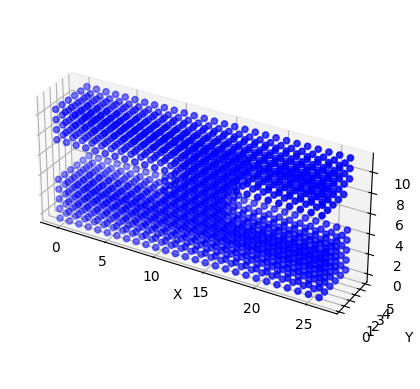

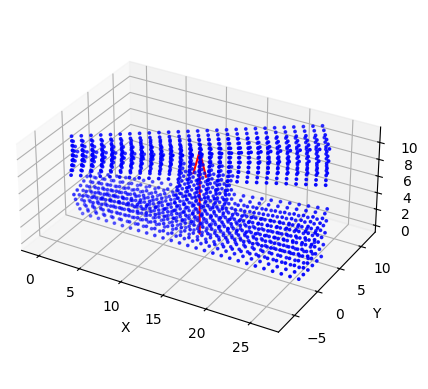

In [8]:
filename = 'I'
args = TrajectoryArgs(
    {
        'input_stl': '../data/stls_ABC_dataset/{filename}.stl'.format(filename=filename),
        'output_vtu': '../data/vtu/{filename}.vtu'.format(filename=filename),
        'output_ascii_vtu': '../data/vtu/{filename}-ascii.vtu'.format(filename=filename),
        'voxel_size': 1,
        'timesteps': 100,
        'output_trajectory_json': '../data/trajectories/{filename}.json'.format(filename=filename),
        'plot': True,
    }
)

generate_trajectory(args.input_stl, args.output_vtu, args.output_ascii_vtu, args.voxel_size, args.timesteps, args.output_trajectory_json, args.plot)

#### Trajectory II

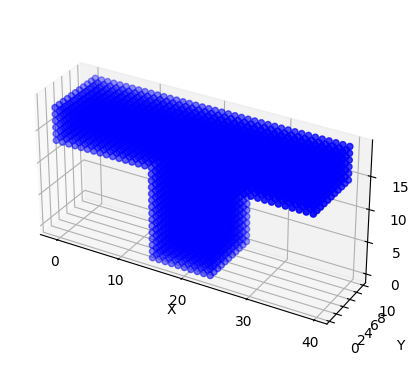

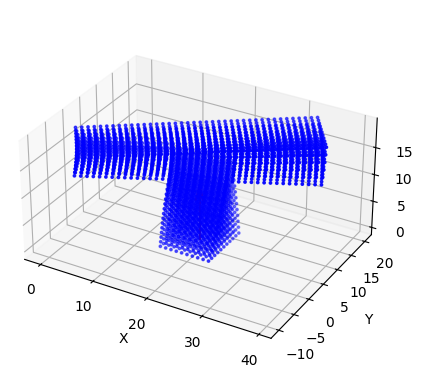

In [9]:
filename = 'T'
args = TrajectoryArgs(
    {
        'input_stl': '../data/stls_ABC_dataset/{filename}.stl'.format(filename=filename),
        'output_vtu': '../data/vtu/{filename}.vtu'.format(filename=filename),
        'output_ascii_vtu': '../data/vtu/{filename}-ascii.vtu'.format(filename=filename),
        'voxel_size': 1,
        'timesteps': 100,
        'output_trajectory_json': '../data/trajectories/{filename}.json'.format(filename=filename),
        'plot': True,
    }
)

generate_trajectory(args.input_stl, args.output_vtu, args.output_ascii_vtu, args.voxel_size, args.timesteps, args.output_trajectory_json, args.plot)